<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230302.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 
import os
import re 

from functools import reduce
from collections import defaultdict
from scipy import stats
from scipy.stats import norm

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mock_sales_data.csv',
 'sales.csv',
 '1_customers_dataset.csv',
 'bz_data_analyis.csv',
 'test.csv',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'online_retail.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ab_experiment.csv',
 'sales_vs_discount.csv',
 'mall_customers.csv',
 'app_wau.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'scanner_data.csv',
 '1_order_payments_dataset.csv',
 'lead_conversion.csv',
 '1_orders_dataset.csv',
 'sample-sales-data.csv',
 'ecommerce-data.csv',
 'online_retail_II.xlsx',
 'cookie_cats.csv',
 'groceries.csv',
 'match_result_test.csv',
 'sales_data_with_stores.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'sample_data']

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index(name = 'cnt')
cnt = cnt[cnt['result'] == True]
cnt

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


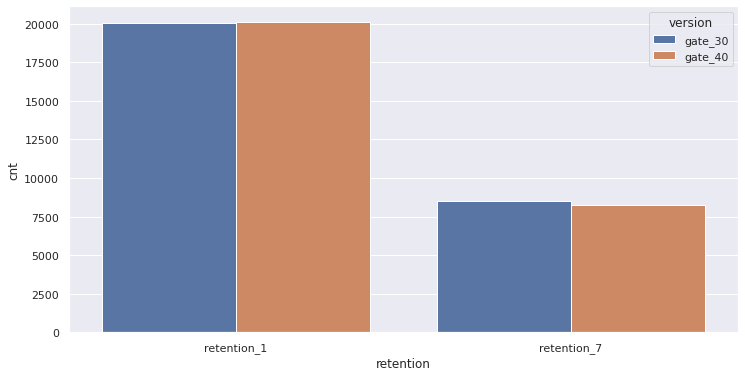

In [7]:
sns.set(rc = {'figure.figsize':[12,6]})
sns.barplot(data = cnt, x = 'retention', y = 'cnt', hue = 'version')
plt.show()

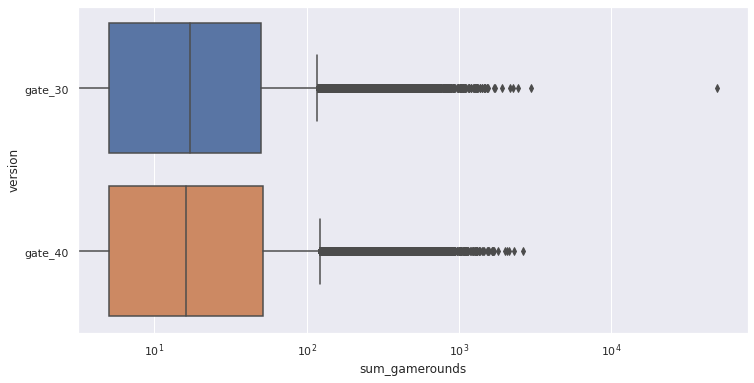

In [9]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

In [10]:
df = df[df['sum_gamerounds'] <= 10000]

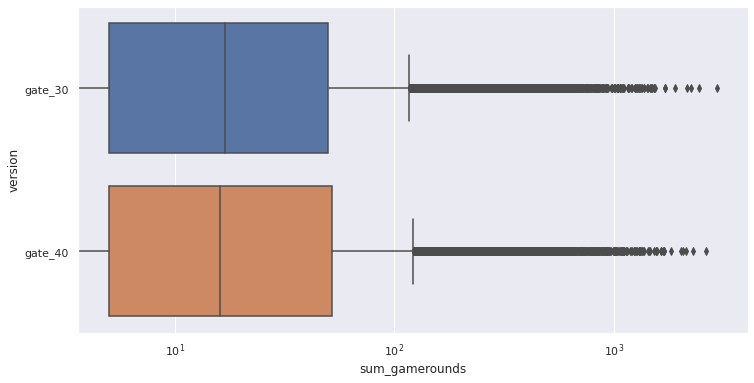

In [11]:
sns.set(rc = {'figure.figsize':[12,6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

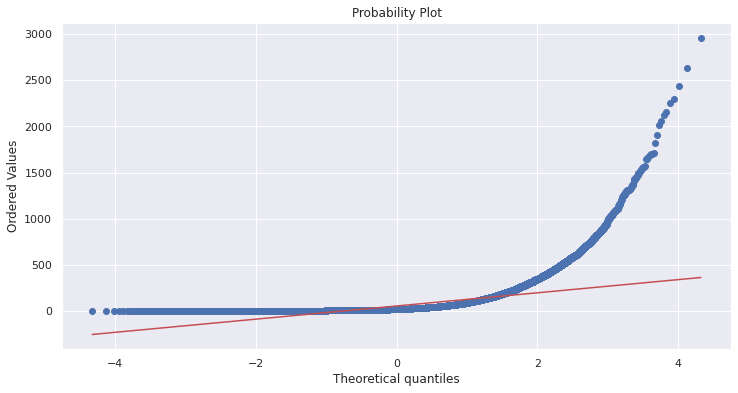

In [12]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)
plt.show()

In [14]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(f'{round(stat,2)}\t{round(p,2)}')

18528909.99	0.0


In [16]:
res = stats.anderson(df['sum_gamerounds'])
res2 = zip(res.critical_values, res.significance_level)

In [17]:
[f'Probably Gaussian : critical value is {crit}, significance level is {sig}'
 if crit > sig
 else f'Probably not Gaussian : critical value is {crit}, significance level is {sig}'
 for crit, sig in res2
]

['Probably not Gaussian : critical value is 0.576, significance level is 15.0',
 'Probably not Gaussian : critical value is 0.656, significance level is 10.0',
 'Probably not Gaussian : critical value is 0.787, significance level is 5.0',
 'Probably not Gaussian : critical value is 0.918, significance level is 2.5',
 'Probably Gaussian : critical value is 1.092, significance level is 1.0']

In [20]:
n = 1000
boots = pd.DataFrame(
    [df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots.head()

version,gate_30,gate_40
sum_gamerounds,49.488965,50.669766
sum_gamerounds,51.197819,49.813923
sum_gamerounds,51.059951,48.689762
sum_gamerounds,50.556238,49.119560
sum_gamerounds,51.603799,51.073526


<AxesSubplot:ylabel='Density'>

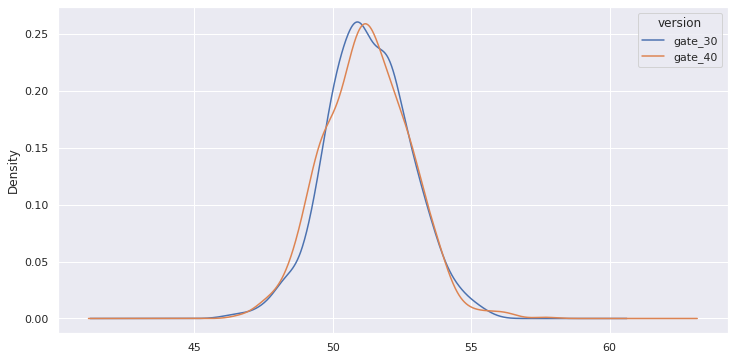

In [21]:
boots.plot.kde()

In [22]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff > 0])/n

0.51

In [24]:
z_mean = np.mean(boots['gate_30']) - np.mean(boots['gate_40'])
z_sigma = np.sqrt(
    np.var(boots['gate_30'])/n + np.var(boots['gate_40'])/n
)
alpha = .05
ci_diff = [z_mean - norm.ppf(1 - alpha/2) * z_sigma, z_mean + norm.ppf(1 - alpha/2) * z_sigma]

In [25]:
print(f'Z Mean : {z_mean}\nZ Sigma : {z_sigma}\nCI DIff : {ci_diff[0]} {ci_diff[1]}')

Z Mean : 0.04864635573942877
Z Sigma : 0.06827477188511613
CI DIff : -0.08516973820808671 0.18246244968694425


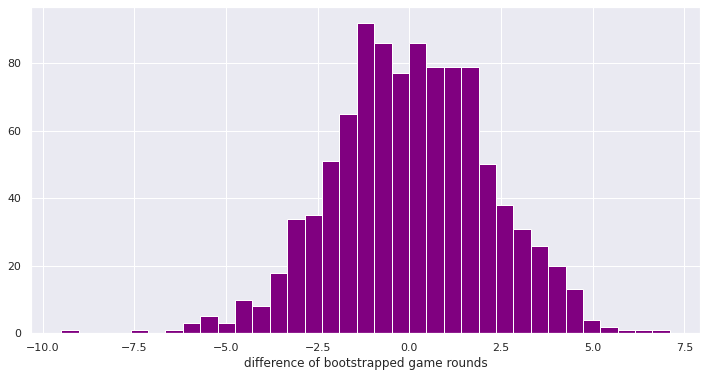

In [26]:
plt.hist(diff, bins = 35, color = 'purple')
plt.xlabel('difference of bootstrapped game rounds')
plt.show()

In [30]:
ct_retention_1 = pd.crosstab(df['version'], df['retention_1'])
ct_retention_7 = pd.crosstab(df['version'], df['retention_7'])
print(ct_retention_1)
print('-'*20)
print(ct_retention_7)

retention_1  False   True
version                  
gate_30      24665  20034
gate_40      25370  20119
--------------------
retention_7  False  True
version                 
gate_30      36198  8501
gate_40      37210  8279


In [31]:
chi2, p, dof, ex = stats.chi2_contingency(ct_retention_1)

In [33]:
print(f'CHI2 : {chi2}, P : {p}, \nDoF : {dof}, \nEX : {ex}')

CHI2 : 3.169835543170799, P : 0.07500999897705693, 
DoF : 1, 
EX : [[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


In [35]:
def get_chi2(data) :
  alpha = .05
  chi2, p, dof, ex = stats.chi2_contingency(data)
  res1 = 'not enough evidence to reject H0' if p > .05 else 'two group is diffferent'
  res2 = f'P {p} > Alpha : {alpha}' if p > alpha else f'P {p} < Alpha : {alpha}'
  print(f'CHI2 : {chi2}, P : {p}, \nDoF : {dof}, \nEX : {ex}')
  print(res2)
  print(res1)

In [36]:
get_chi2(ct_retention_1)

CHI2 : 3.169835543170799, P : 0.07500999897705693, 
DoF : 1, 
EX : [[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]
P 0.07500999897705693 > Alpha : 0.05
not enough evidence to reject H0


In [37]:
get_chi2(ct_retention_7)

CHI2 : 9.91527552890567, P : 0.0016391259678654425, 
DoF : 1, 
EX : [[36382.49203885  8316.50796115]
 [37025.50796115  8463.49203885]]
P 0.0016391259678654425 < Alpha : 0.05
two group is diffferent


# Iterators

In [38]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [39]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])' ) for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}